In [169]:
# Import the necessary libraries
import pandas as pd

# Define the file paths
subdirectory = "pickle_data_Kuchen"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
#test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(test_features.head())

Loaded Training features dimensions: (1462, 39)
Loaded Validation features dimensions: (357, 39)
Loaded Test features dimensions: (355, 39)

Loaded Training labels dimensions: (1462, 1)
Loaded Validation labels dimensions: (357, 1)

First few rows of loaded training features:
      Temp_Cold  Temp_Mild  Temp_Warm  Temp_Hot  Cloud_ok  Cloud_Cloudy  \
5795          0          1          0         0         0             1   
5796          0          1          0         0         1             0   
5797          0          0          1         0         0             1   
5798          0          1          0         0         0             1   
5799          0          1          0         0         1             0   

      KielerWoche  Montag  Dienstag  Mittwoch  ...  Monat_4  Monat_5  Monat_6  \
5795            0       1         0         0  ...        0        0        0   
5796            0       0         1         0  ...        0        0        0   
5797            0       0    

In [170]:
#Defining the Neural Network
#Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam # --> Optimierungsalgorithmus
import tensorflow as tf


#Sequential ermöglicht das Erstellen eines Modells mit einer Schicht nach der abnderen
#Dense sind die Schichten, die Eingaben mit Gewichten und einer Aktivierungsfunktion kombinieren
model = Sequential([
  InputLayer(shape=(training_features.shape[1], )),
  Dropout(0.1),  
  #BatchNormalization(), hat keinen Vorteil gebracht, da alle Werte entweder one hot encoded sind oder bereits skaliert wurden
  Dense(64, activation='relu'),# --> 1. Schicht mit ReLU Aktivierungsfunktion (rectified linear unit), um Nichtlinearität in das Modell reinzubringen
  #Dropout(0.1),
  Dense(32, activation='relu'),
  Dense(1) # keine Aktivierungsfunktion --> Regression (um kontinuierliche Were als Output zu erhalten)
])

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 39)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
# Compiling and Training the model with mean squared Error (MSE) as loss function and adam optimizer
model.compile(loss="mse", optimizer=Adam(learning_rate=0.0015, beta_1=0.95, beta_2=0.95), metrics = ['mape']) # Mean Absolute Error zur Überwachung


#checkpoint Callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_checkpoints.weights.h5', save_weights_only=True)

#early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(training_features, training_labels, epochs=200, 
                    batch_size = 32, 
                    verbose =1,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[checkpoint_cb, early_stopping_cb])


# Infos zum Output:
# 235/235 bedeutet, dass Datensatz in 235 Batches aufgeteilt wurde und alle Batches für diese Epoche verarbeitet wurden
#1s 2ms/step: Zeit, die für die gesamte Epoche benötigt wurde (1 Sekunde) und durchschnittlich 2 Millisekunden pro Schritt
#loss: 63840.3867: Der Trainingsverlust (Loss) nach dieser Epoche. Ein hoher Wert bedeutet, dass das Modell noch weit davon entfernt ist, optimale Vorhersagen zu treffen.
#val_loss: 51443.0977: Der Validierungsverlust (Loss) für diese Epoche. Das ist der Verlust auf den Validierungsdaten, die nicht für das Training verwendet werden, sondern zur Überprüfung der Modellleistung dienen

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 84480.1406 - mape: 99.3121 - val_loss: 69935.6406 - val_mape: 95.6564
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 76300.5781 - mape: 93.7381 - val_loss: 52564.1172 - val_mape: 80.3027
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 53060.2930 - mape: 76.5631 - val_loss: 23604.1758 - val_mape: 45.2141
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26772.4570 - mape: 42.0402 - val_loss: 8816.1836 - val_mape: 25.7984
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10772.2754 - mape: 25.2081 - val_loss: 9206.5928 - val_mape: 28.2497
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9886.2256 - mape: 21.8290 - val_loss: 7946.4355 - val_mape: 24.8621
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14422.4883 - mape: 20.6367 - val_loss: 7364.4951 - val_mape: 23.3774
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5811.5200 - mape: 18.8336 - val_loss: 717

In [172]:
# Saving the trained Model
model.save("python_model_kuchen.h5")

In [173]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAPE on the Training Data: 11.74%
MAPE on the Validation Data: 13.47%


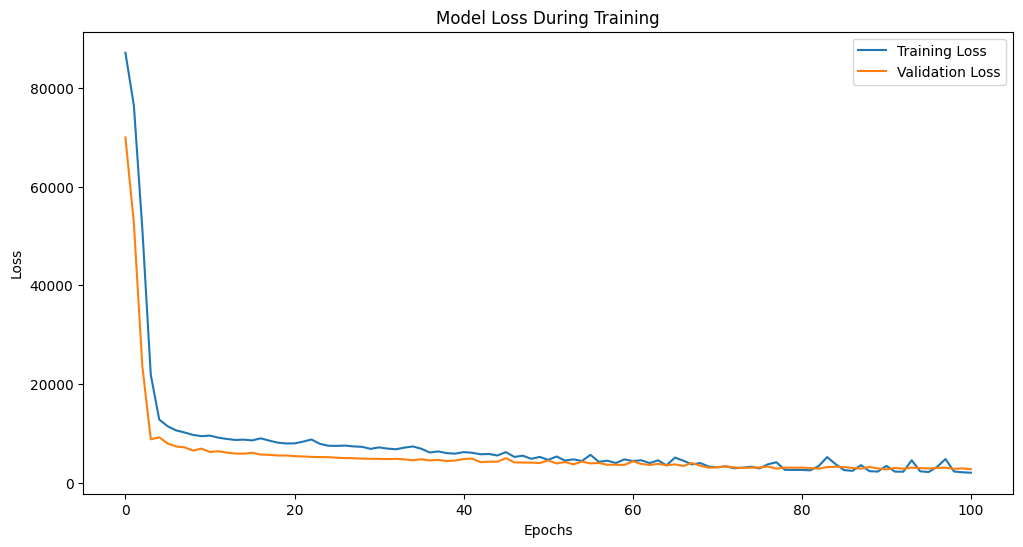

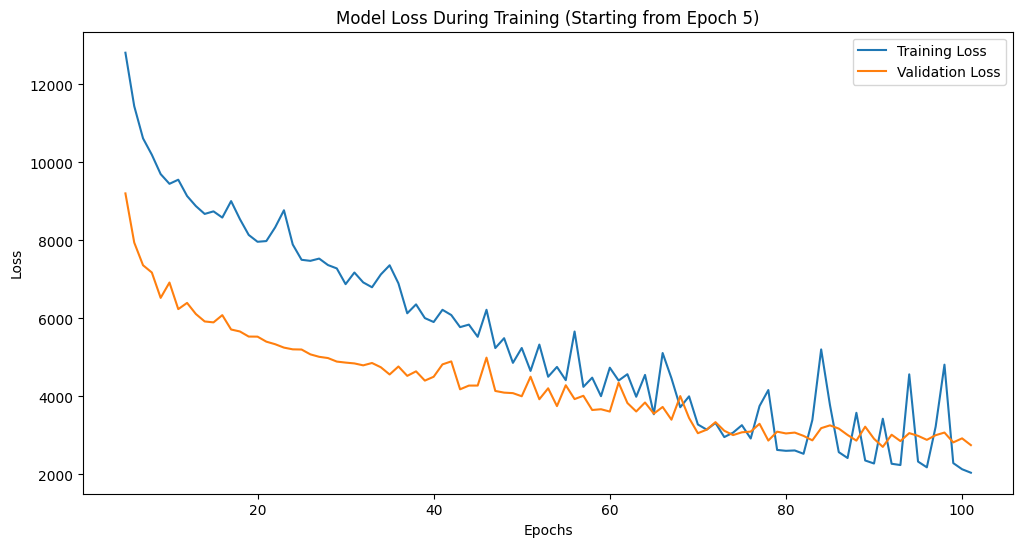

In [174]:
# Plotting Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training History (ab der 5. Epoche)
import matplotlib.pyplot as plt

# Schneide die Verlaufsdaten ab der 5. Epoche
epochs_to_plot = range(5, len(history.history['loss']) + 1)
training_loss = history.history['loss'][4:]
validation_loss = history.history['val_loss'][4:]

plt.figure(figsize=(12, 6))
plt.plot(epochs_to_plot, training_loss, label='Training Loss')
plt.plot(epochs_to_plot, validation_loss, label='Validation Loss')
plt.title('Model Loss During Training (Starting from Epoch 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


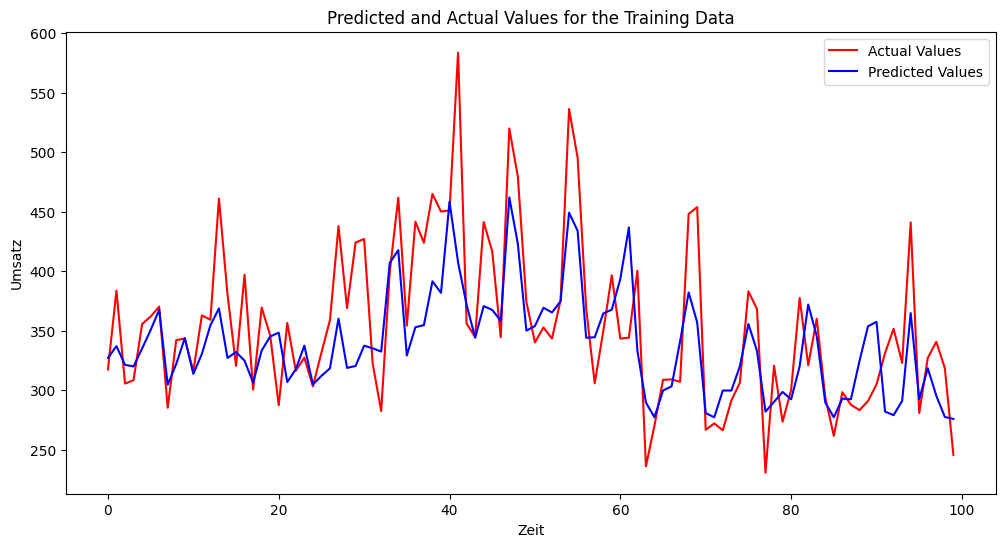

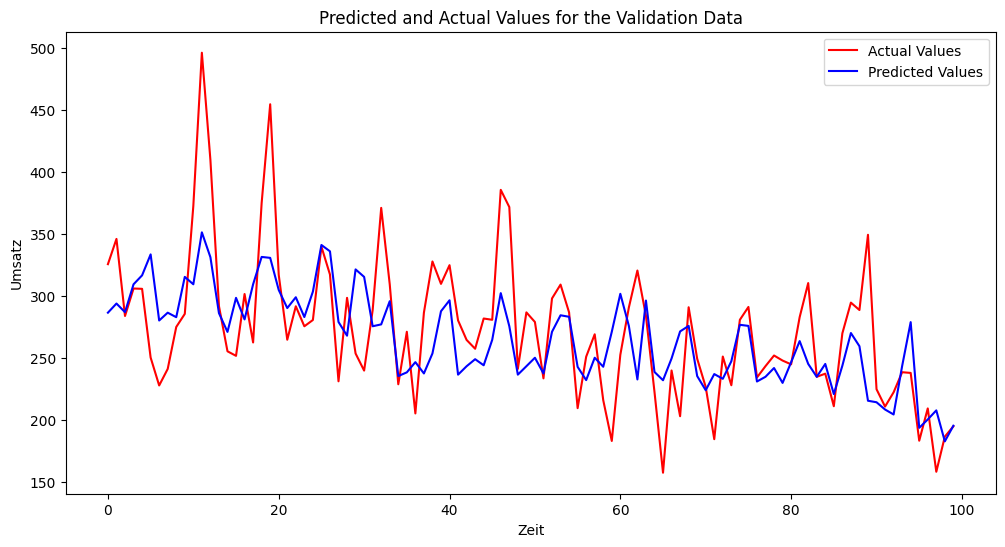

In [175]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

In [176]:
pred = model.predict(test_features)
pred = pd.DataFrame(pred)
pred


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


,0
0,259.076385
1,235.346268
2,256.879242
3,271.983246
4,292.869537
...,...
350,234.776611
351,252.787430
352,266.403137
353,231.263809


In [177]:
test_data = pd.read_csv('../../../0_DataPreparation/00_data/Testdaten.csv')
test_data = test_data[test_data["Warengruppe_5"] == 1]
test_data

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold,Temp_Cold,...,Monat_7,Monat_8,Monat_9,Monat_10,Monat_11,Monat_12,zwischen_den_jahren,Number_of_ships_scaled,Cloud_ok,Wind_ok
1419,1808015,2018-08-01,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,1,1
1420,1808025,2018-08-02,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,1,1
1421,1808035,2018-08-03,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,1,1
1422,1808045,2018-08-04,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.2,1,1
1423,1808055,2018-08-05,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,1907265,2019-07-26,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.0,1,1
1770,1907275,2019-07-27,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.6,1,0
1771,1907285,2019-07-28,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.4,1,1
1772,1907295,2019-07-29,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.2,0,1


In [178]:

# let's merge predictions with the 'id' column:
predictions_df = pd.DataFrame({
    'id': test_data['id'].values,
    'Umsatz': pred[0].values
}).reset_index(drop=True)

predictions_df

,id,Umsatz
0,1808015,259.076385
1,1808025,235.346268
2,1808035,256.879242
3,1808045,271.983246
4,1808055,292.869537
...,...,...
350,1907265,234.776611
351,1907275,252.787430
352,1907285,266.403137
353,1907295,231.263809


In [179]:
# Speichert den DataFrame als CSV-Datei für die Kaggle-Submission
# index=False verhindert, dass eine zusätzliche Indexspalte geschrieben wird
predictions_df.to_csv('02_Kuchen_predictions.csv', index=False)